# Sequentially Comparing Forecasters on Synthetic Data

Here, we compare our e-processes against the **Diebold-Mariano (DM)** test of _unconditional_ predictive ability and the **Giacomini-White (GW)** test of _conditional_ predictive ability. 
Both are asymptotic tests with stationarity/mixing assumptions; each also has some modeling assumption (error-based losses for DM; linear conditional models for GW).

We use the package [`epftoolbox`](https://epftoolbox.readthedocs.io/en/latest/) to implement the DM and GW tests. (It requires `tensorflow>=2.2` although we don't use the functionality here.)

See also: Section H.2 in our paper.

YJ Choe [yjchoe@cmu.edu]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os.path

import comparecast as cc

In [2]:
from epftoolbox.evaluation import DM
from epftoolbox.evaluation.gw import gwtest

## Hyperparameter Settings

In [3]:
# which scoring rule to use
scoring_rule = "brier"

# significance level
alpha = 0.05

# whether to use the log scale on x-axis (time)
use_logx = False

# size up label fonts
font_scale = 1.75

## Forecasts on Synthetic Data

To compare the validity of p-processes, we choose a case where the the null is true, i.e., 

$$\mathcal{H}_0: \Delta_t \leq 0,\; \forall t$$.

We create a case where there reality is non-stationary and also not noisy.

In [4]:
data_name = "default_noiseless"
data_file = f"forecasts/{data_name}.csv"
plots_dir = f"plots/{data_name}_with_dm"

# data = cc.data_utils.synthetic.get_data("default", size=10000, noise=0.0)
# data.to_csv(data_file, index=False)
data = cc.data_utils.synthetic.get_data(data_file, size=10000, noise=0.0)
data

,time,y,true_probs
0,1,0,0.5
1,2,0,0.5
2,3,1,0.5
3,4,1,0.5
4,5,0,0.5
...,...,...,...
9995,9996,0,0.2
9996,9997,1,0.2
9997,9998,0,0.2
9998,9999,1,0.2


In [5]:
data["optimist"] = np.concatenate([
    np.repeat(0.6, 2000+1),
    np.repeat(0.9, 2000),
    np.repeat(0.3, 2000),
    np.repeat(0.9, 2000),
    np.repeat(0.3, 2000-1),
])    # too optimistic
data["pessimist"] = np.concatenate([
    np.repeat(0.4, 2000+1),
    np.repeat(0.7, 2000),
    np.repeat(0.1, 2000),
    np.repeat(0.7, 2000),
    np.repeat(0.1, 2000-1),
])

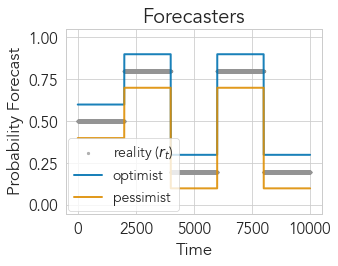

In [6]:
cc.plot_forecasts(
    data, 
    forecasters=["optimist", "pessimist"], 
    plots_dir=plots_dir, 
    use_logx=use_logx,
    font_scale=font_scale,
    figsize=(5, 4),
    legend_out=False,
)
plt.legend(loc="lower left", fontsize="small", bbox_to_anchor=(-0.02, -0.025))
#plt.legend(loc="upper center", ncol=3, fontsize="small", bbox_to_anchor=(0.425, 1.35))
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "forecasters.pdf"))

In [7]:
cc.compute_true_deltas(
    data["optimist"],
    data["pessimist"],
    data["true_probs"],
    scoring_rule=scoring_rule
)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -1.20024005e-05, -1.20012001e-05, -1.20000000e-05])

## CS for $\Delta_t(\hat{p}_\text{k29-poly3}, \hat{p}_\text{laplace})$

In [8]:
name_p, name_q = "optimist", "pessimist"
results = cc.compare_forecasts(
    data, 
    name_p, 
    name_q, 
    scoring_rule=scoring_rule,
    alpha=alpha,
)
results

,time,lcb,ucb,e_pq,e_qp
0,1,-10.286275,9.886275,0.902317,1.054496
1,2,-5.243138,4.843138,0.835592,1.141155
2,3,-3.428758,3.295425,0.823937,0.959435
3,4,-2.521569,2.521569,0.856047,0.856047
4,5,-2.057255,1.977255,0.778617,0.904531
...,...,...,...,...,...
9995,9996,-0.008811,0.004930,0.018498,0.117144
9996,9997,-0.008780,0.004963,0.018673,0.114409
9997,9998,-0.008787,0.004954,0.018628,0.115070
9998,9999,-0.008755,0.004987,0.018805,0.112398


calculating diagnostics under repeated sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:19:26<00:00, 47.67s/it]


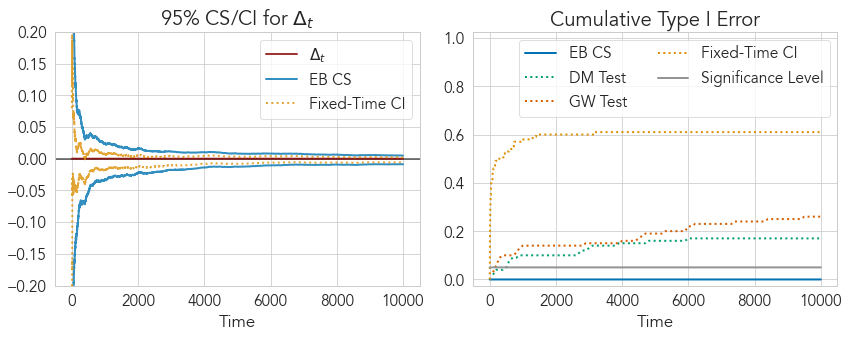

In [9]:
results, axes = cc.plot_comparison(
    data, 
    name_p, 
    name_q, 
    scoring_rule=scoring_rule,    
    plots_dir=plots_dir, 
    alpha=alpha,
    baselines=("ci"),
    plot_e=False,
    plot_diagnostics=True,
    diagnostics_fn="cfdr",
    diagnostics_baselines=("dm", "gw", "ci"),
    n_repeats=100,
    plot_width=False,
    use_logx=use_logx,
    ylim_scale=0.2,
    font_scale=font_scale,
    no_title=True,
)

## DM/GW Tests of (Un)conditional Predictive Ability

These tests are NOT anytime-valid and are asymptotic. They also come with different assumptions which are not often checked in practice (Diebold 2013).

### DM Test

In [10]:
# use squared loss
norm = 2
T = len(data)
mid_T = 4000

# hack to make it 2 columns (second column not meaningful)
y, fc_p, fc_q = [
    np.vstack([data[column].values, 1 - data[column].values]).T
    for column in ["y", name_p, name_q]
]

# direction is in reverse to our null
print(f"DM p-value at T={mid_T}:", DM(y[:mid_T], fc_q[:mid_T], fc_p[:mid_T], norm=norm))
print(f"DM p-value at T={T}:", DM(y, fc_q, fc_p, norm=norm))

DM p-value at T=4000: [0.71988521 0.71988521]
DM p-value at T=10000: [0.86912347 0.86912347]


In [11]:
DM(y, fc_q, fc_p, norm=norm)

array([0.86912347, 0.86912347])

In [12]:
cc.compute_cfdr(DM(y, fc_q, fc_p, norm=norm))

array([False, False])

### GW Test

In [13]:
# default option 'GW' only supports (hardcoded) the format of 24-forecasts-per-day
from epftoolbox.evaluation.gw import gwtest

score_fn = cc.get_scoring_rule("brier")

loss_p = 1 - score_fn(y, fc_p)
loss_q = 1 - score_fn(y, fc_q)

print(f"GW p-value at T={mid_T}:", gwtest(loss_q[:mid_T], loss_p[:mid_T], tau=1, conditional=True))
print(f"GW p-value at T={T}:", gwtest(loss_q, loss_p, tau=1, conditional=True))

GW p-value at T=4000: 1.0
GW p-value at T=10000: 1.0


### Both at different sample sizes (unsafe)

In [14]:
# non-anytime-valid p-values
from tqdm.notebook import tqdm

n_interval = 100
unsafe_p = pd.DataFrame([
    {
        "Time": t,
        "DM": DM(y[:t], fc_q[:t], fc_p[:t], norm=norm)[0],
        "GW": gwtest(loss_q[:t], loss_p[:t], tau=1, conditional=True),
    }
    for t in tqdm(data.time[n_interval-1::n_interval])
]).melt(id_vars=["Time"], var_name="Test", value_name="p-value")

unsafe_p

  0%|          | 0/100 [00:00<?, ?it/s]

,Time,Test,p-value
0,100,DM,0.579275
1,200,DM,0.714350
2,300,DM,0.822537
3,400,DM,0.971845
4,500,DM,0.858712
...,...,...,...
195,9600,GW,1.000000
196,9700,GW,1.000000
197,9800,GW,1.000000
198,9900,GW,1.000000


## Comparison with Anytime-Valid $p$-Values

Any e-process $(E_t)_{t \geq 0}$ can be converted into an anytime-valid p-process $(\mathsf{p}_t)_{t\geq0}$ via the simple conversion formula $\mathsf{p}_t = 1/E_t$.

In [15]:
results = cc.compare_forecasts(
    data, 
    name_p, 
    name_q, 
    scoring_rule=scoring_rule,
    alpha=alpha,
)
results

,time,lcb,ucb,e_pq,e_qp
0,1,-10.286275,9.886275,0.902317,1.054496
1,2,-5.243138,4.843138,0.835592,1.141155
2,3,-3.428758,3.295425,0.823937,0.959435
3,4,-2.521569,2.521569,0.856047,0.856047
4,5,-2.057255,1.977255,0.778617,0.904531
...,...,...,...,...,...
9995,9996,-0.008811,0.004930,0.018498,0.117144
9996,9997,-0.008780,0.004963,0.018673,0.114409
9997,9998,-0.008787,0.004954,0.018628,0.115070
9998,9999,-0.008755,0.004987,0.018805,0.112398


In [16]:
def convert_e_to_p(e):
    """Convert an e-process into an anytime-valid p-process via
    
    p_t = 1/E_t.
    """
    return np.clip(1.0 / (e + 1e-8), 0, 1)

In [17]:
safe_e = results["e_pq"].values
safe_p = convert_e_to_p(safe_e)
safe_p = pd.DataFrame([
    {
        "Time": t,
        "Test": "CR (anytime-valid)",
        "p-value": p,
    }
    for t, p in zip(data.time[n_interval-1::n_interval], 
                    safe_p[n_interval-1::n_interval])
])

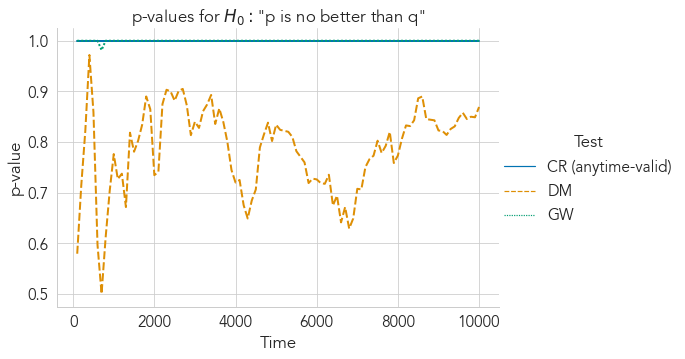

In [18]:
pvalues = pd.concat([safe_p, unsafe_p], ignore_index=True)

fg = sns.relplot(
    x="Time",
    y="p-value",
    kind="line",
    linewidth=2,
    hue="Test",
    style="Test",
    aspect=1.5,
    data=pvalues
)
fg.ax.set(
    title="p-values for " + r"$H_0:$" + "\"p is no better than q\"",
)
# fg.ax.axhline(y=0.05, color="gray", alpha=0.5, linewidth=2)
fg.savefig(os.path.join(plots_dir, "pvalue_comparison.pdf"))
None

## *DM Assumptions

In particular: covariance stationarity (clearly violated in the above examples).

In [19]:
deltas = cc.cumul_mean(loss_q - loss_p)

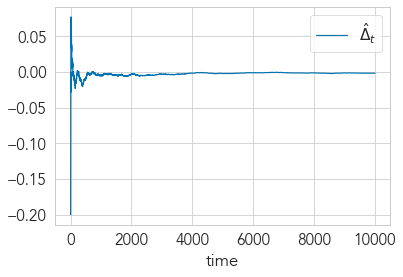

In [20]:
sns.lineplot(x=data.time, y=deltas, label=r"$\hat\Delta_t$")
None

In [21]:
import statsmodels.api as sm

# H_0: white noise vs. H_1: not white noise
sm.stats.acorr_ljungbox(deltas, lags=1)

,lb_stat,lb_pvalue
1,7039.560538,0.0


In [ ]:
import statsmodels.tsa.api as tsa

# H_0: non-stationary vs. H_1: AR(1) stationary
tsa.adfuller(deltas)

(-6.253783289287301,
 4.388988062747655e-08,
 38,
 9961,
 {'1%': -3.4310066595695945,
  '5%': -2.861830204343065,
  '10%': -2.5669244706354584},
 -134957.87532730523)